# More Realistic Galaxy Populations

Most global 21-cm examples in the documentation tie the volume-averaged emissivity of galaxies to the rate at which mass collapses into dark matter halos (this is the default option in *ARES*). Because of this, they are referred to as $f_{\text{coll}}$ models throughout, and are selected by setting ``pop_sfr_model='fcoll'``. In the code, they are represented by ``GalaxyAggregate`` objects, named as such because galaxies are only modeled in aggregate, i.e., there is no distinction in the properties of galaxies as a function of mass, luminosity, etc.

However, we can also run more detailed models in which the properties of galaxies are allowed to change as a function of halo mass, redshift, and/or potentially other quantities.

A few usual imports before we begin:

In [1]:
%matplotlib inline
import ares
import numpy as np
import matplotlib.pyplot as plt

## Double Power-Law Star Formation Efficiency

The most common extension to simple models is to allow the star formation efficiency (SFE) to vary as a function of halo mass. This is motivated observationally by the mismatch in the shape of the galaxy luminosity function (LF) and dark matter halo mass function (HMF). In [Mirocha, Furlanetto, & Sun (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.464.1365M>), we adopted a double power-law form for the SFE, i.e., 

\begin{equation}
f_{\ast}(M_h) = \frac{2 f_{\ast,p}} {\left(\frac{M_h}{M_{\text{p}}} \right)^{\gamma_{\text{lo}}} + \left(\frac{M_h}{M_{\text{p}}}  \right)^{\gamma_{\text{hi}}}}
\end{equation}

where the free parameters are the normalization, $f_{\ast,p}$, the peak mass, $M_p$, and the power-law indices in the low-mass and high-mass limits, $\gamma_{\text{lo}}$ and $\gamma_{\text{hi}}$, respectively. Combined with a model for the mass accretion rate onto dark matter halos ($\dot{M}_h$; see next section), the star formation rate as computed as

\begin{equation}
\dot{M}_{\ast} = f_{\ast} \left(\frac{\Omega_{b,0}}{\Omega_{m,0}} \right) \dot{M}_h
\end{equation}

In general, the SFE curve must be calibrated to an observational dataset (see [Fitting to UVLFs](example_mcmc_lf)), but you can also just grab our best-fitting parameters for a redshift-independent SFE curve as follows:

In [2]:
p = ares.util.ParameterBundle('mirocha2017:base')
pars = p.pars_by_pop(0, strip_id=True)

The second command extracts only the parameters associated with population #0, which is the stellar population in this calculation (population #1 is responsible for X-ray emission only; see [Models with Multiple Source Populations](example_gs_multipop) for more info on the approach to populations in *ARES*). Passing ``strip_id=True`` removes all ID numbers from parameter names, e.g., ``pop_sfr_model{0}`` becomes ``pop_sfr_model``. The reason for doing that is so we can generate a single ``GalaxyPopulation`` instance, e.g.,

In [3]:
pop = ares.populations.GalaxyPopulation(**pars)

If you glance at the contents of ``pars``, you'll notice that the parameters that define the double power-law share a ``pq`` prefix. This is short for "parameterized quantity", and is discussed more generally on the page about the [ParameterizedQuantity object](../uth_pq.html).

**NOTE:** You can access population objects used in a simulation via the ``pops`` attribute, which is a list of population objects that belongs to instances of  common simulation classes like ``Global21cm``, ``MetaGalacticBackground``, etc.

Now, to generate a model for the luminosity function, simply define your redshift of interest and array of magnitudes (assumed to be rest-frame $1600 \unicode{x212B}$ AB magnitudes), and pass them to the aptly named ``LuminosityFunction`` function,

# Loaded $ARES/halos/halo_mf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.
# Loaded $ARES/bpass_v1/SEDS/sed.bpass.constant.nocont.sin.z020


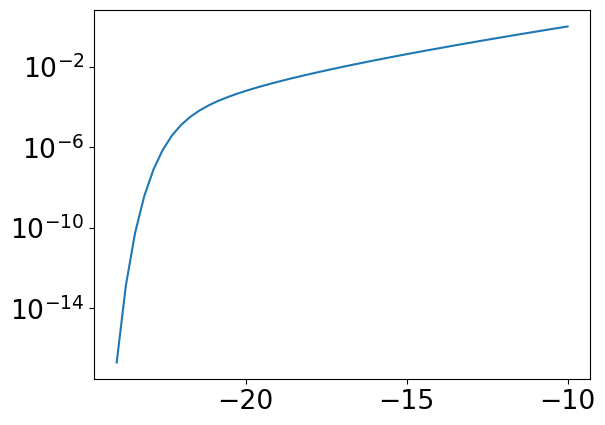

In [4]:
z = 6
MUV = np.linspace(-24, -10)
_bins, lf = pop.get_lf(z, MUV)

plt.semilogy(MUV, lf)

To compare to the observed galaxy luminosity function, we can use some convenience routines setup to easily access and plot measurements stored in the *ARES* ``litdata`` module:

/Users/jmirocha/Work/soft/miniconda3/lib/python3.9/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


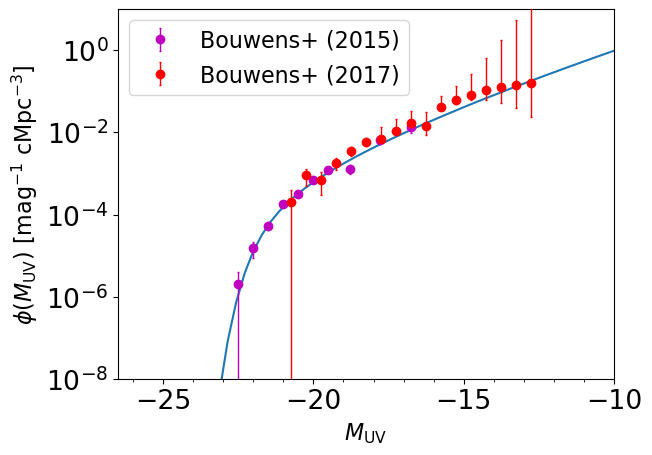

In [5]:
obslf = ares.analysis.GalaxyPopulation()
ax = obslf.Plot(z=z, round_z=0.2)
ax.semilogy(MUV, lf)
ax.set_ylim(1e-8, 10)
ax.legend()

The ``round_z`` keyword argument makes it so that any dataset available in the range $5.8 \leq z \leq 6.2$ gets included in the plot. Similarly, the ``round_wave`` keyword argument will loosen the restriction that luminosity functions be an exact match for the supplied wavelength `wave`. To do this for multiple redshifts at the same time, you could do something like:

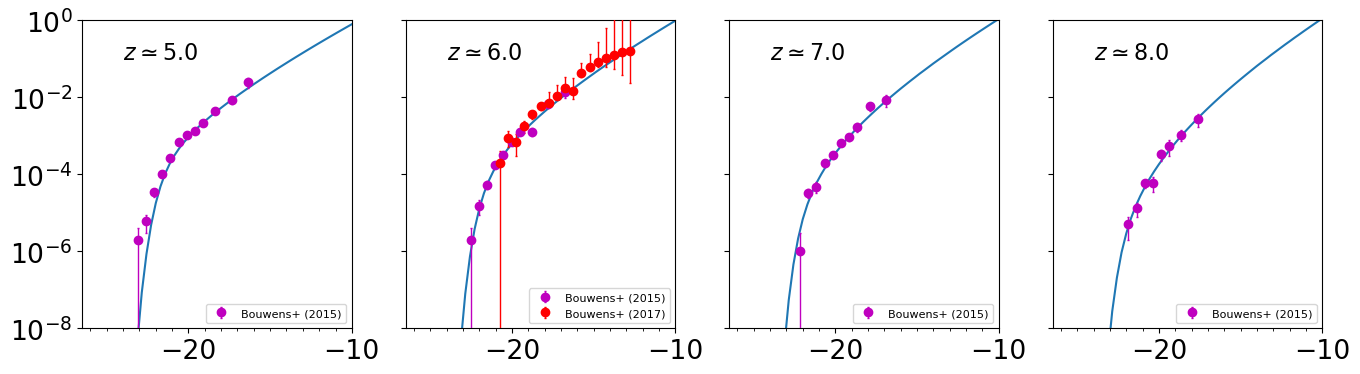

In [6]:
redshifts = [5,6,7,8]
MUV = np.linspace(-24, -10)


# Create a 1x4 panel plot, include all available data sources
fig, axes = plt.subplots(1, len(redshifts), figsize=(4*len(redshifts), 4))

for i, z in enumerate(redshifts):
    obslf.Plot(z=z, round_z=0.3, wavelength=1600, round_wave=0, ax=axes[i])
    
    _bins, lf = pop.get_lf(z, MUV)
    axes[i].semilogy(MUV, lf)
    axes[i].annotate(r'$z \simeq %.1f$' % z, (-24, 1e-1))
    axes[i].legend(loc='lower right', fontsize=8)
    
    axes[i].set_ylim(1e-8, 1)
    if i > 0:
        axes[i].set_yticklabels([])

To create the ``GalaxyPopulation`` used above from scratch (i.e., without using parameter bundles), we could have just done:

In [8]:
pars = \
{
 'pop_sfr_model': 'sfe-func',
 'pop_sed': 'bpass_v1',


 'pop_fstar': 'pq',
 'pq_func': 'dpl',
 'pq_func_par0': 0.05,
 'pq_func_par1': 2.8e11,
 'pq_func_par2': 0.51,
 'pq_func_par3': -0.61,
 'pq_func_par4': 1e10,  # halo mass at which SFE is normalized
}
    

pop = ares.populations.GalaxyPopulation(**pars)

**NOTE:** Beware that by default, the double power-law is normalized at $M_h = 10^{10} \ M_{\odot}$ (see ``ps_func_par4`` above), whereas the Equation above for $f_{\ast}$ is defined such that ``pq_func_par0`` refers to the SFE at the peak mass. If you prefer a peak-normalized SFE, you can set ``pq_func='dpl_normP'`` instead.

### Accretion Models

By default, *ARES* will derive the mass accretion rate (MAR) onto halos from the HMF itself (see Section 2.2 of [Furlanetto et al. 2017](http://adsabs.harvard.edu/abs/2017MNRAS.472.1576F>) for details). That is, ``pop_MAR='hmf'`` by default. There are also two other options:

* Plug-in your favorite mass accretion model as a lambda function, e.g., ``pop_MAR=lambda z, M: 1. * (M / 1e12)**1.1 * (1. + z)**2.5``.
* Grab a model from ``data``. The median MAR from McBride et al. (2009) is included (same as above equation), and can used as ``pop_MAR='mcbride2009'``. If you'd like to add more options, use ``ares/data/mcbride2009.py`` as a guide.

**WARNING:** Note that the MAR formulae determined from numerical simulations may not have been calibrated at the redshifts most often targeted in *ARES* calculations, nor are they guaranteed to be self-consistent with the HMF used in *ARES*. One approach used in [Sun \& Furlanetto (2016)](http://adsabs.harvard.edu/abs/2016MNRAS.460..417S>) is to re-normalize the MAR by requiring its integral to match that predicted by $f_{\text{coll}}(z)$, which can boost the accretion rate at high redshifts by a factor of few. Setting ``pop_MAR_conserve_norm=True`` will enforce this condition in *ARES*.

See [this page](../uth_pop_halo.html) for more information.